# Identifying Entities in Healthcare Data

## Workspace set up: Import and Install useful packages.

In [137]:
!pip install pycrf
!pip install sklearn-crfsuite

import spacy
import sklearn_crfsuite
from sklearn_crfsuite import metrics

model = spacy.load("en_core_web_sm")

## Data Preprocessing

The dataset provided is in the form of one word per line. Let's understand the format of data below:
- Suppose there are *x* words in a sentence, then there will be *x* continuous lines with one word in each line. 
- Further, the two sentences are separated by empty lines. The labels for the data follow the same format.

**We need to pre-process the data to recover the complete sentences and their labels.**


### Construct the proper sentences from individual words and print the 5 sentences.

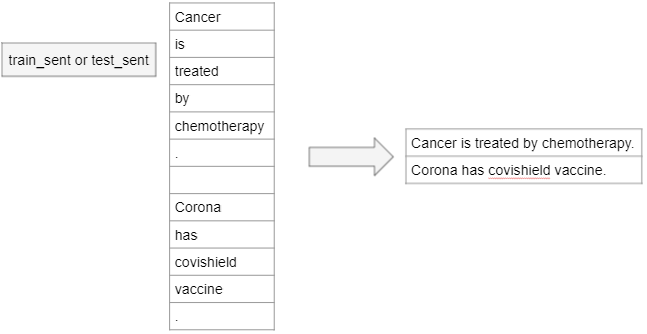

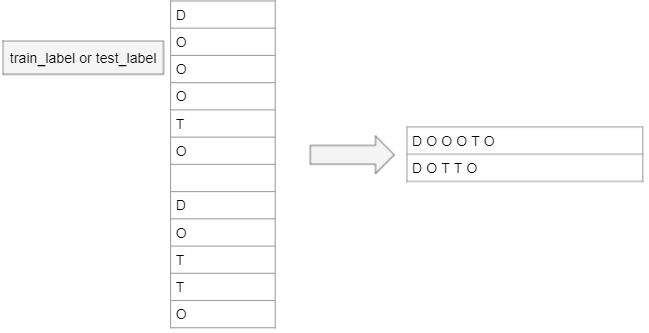

In [138]:
import pandas as pd
import nltk
import spacy
import sklearn_crfsuite
from sklearn_crfsuite import metrics
model = spacy.load("en_core_web_sm")

In [139]:
with open('train_sent', 'r') as train_sent_file:
  train_sentences = train_sent_file.readlines()

with open('train_label', 'r') as train_labels_file:
  train_labels = train_labels_file.readlines()

with open('test_sent', 'r') as test_sent_file:
  test_sentences = test_sent_file.readlines()

with open('test_label', 'r') as test_labels_file:
  test_labels = test_labels_file.readlines()

In [140]:
train_sentences_list = []
test_sentences_list = []

train_labels_list = []
test_labels_list = []

sentence = ''
labels = ''
counter = 0
for w in train_sentences:
    sentence += w
    labels += train_labels[counter]
    if w == '\n':
        sentence = sentence.replace('\n', ' ')
        labels = labels.replace('\n', ' ')
        train_sentences_list.append(sentence.strip())
        train_labels_list.append(labels.strip())
        sentence = ''
        labels = ''
    counter += 1
    
sentence = ''
labels = ''
counter = 0 
for w in test_sentences:
    sentence += w
    labels += test_labels[counter]
    if w == '\n':
        sentence = sentence.replace('\n', ' ')
        labels = labels.replace('\n', ' ')
        test_sentences_list.append(sentence.strip())
        test_labels_list.append(labels.strip())
        sentence = ''
        labels = ''
    counter += 1

In [141]:
train_sentences_list[1]

'The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )'

In [142]:
train_labels_list[1]

'O O O O O O O O O O O O O O O O O O O O O O O O O'

### Count the number of sentences in the processed train and test dataset 

In [143]:
print(len(train_sentences_list))
print(len(test_sentences_list))

2599
1056


### Count the number of lines of labels in the processed train and test dataset.

In [144]:
print(len(train_labels_list))
print(len(test_labels_list))

2599
1056


## Concept Identification

We will first explore what are the various concepts present in the dataset. For this, we will use PoS Tagging. 



### Extract those tokens which have NOUN or PROPN as their PoS tag and find their frequency

In [145]:
document = train_sentences_list + test_sentences_list
len(document)

3655

### Print the top 25 most common tokens with NOUN or PROPN PoS tags

In [146]:
tokens = []
for sent in document:
    doc = model(sent)
    for tok in doc:
        if tok.pos_=="NOUN" or tok.pos_ == 'PROPN':
            tokens.append(tok.lemma_.lower())

In [147]:
tokens=pd.Series(tokens)
tokens.value_counts().head(25)

patient         568
treatment       316
%               247
study           236
cancer          226
cell            203
therapy         182
effect          181
disease         170
group           145
case            132
result          121
lung            120
gene            111
year            105
rate            103
chemotherapy     91
use              91
trial            90
woman            89
conclusion       89
analysis         86
protein          82
response         81
risk             78
dtype: int64

## Defining features for CRF





In [148]:
# Let's define the features to get the feature value for one word.
def getFeaturesForOneWord(sentence, pos):
  word = sentence[pos]

  features = [
    'word.lower=' + word.lower(), # serves as word id
    'word[-3:]=' + word[-3:],     # last three characters
    'word[-2:]=' + word[-2:],     # last two characters
    'word.isupper=%s' % word.isupper(),  # is the word in all uppercase
    'word.isdigit=%s' % word.isdigit(),  # is the word a number
    'words.startsWithCapital=%s' % word[0].isupper() # is the word starting with a capital letter
  ]

  if(pos > 0):
    prev_word = sentence[pos-1]
    features.extend([
    'prev_word.lower=' + prev_word.lower(), 
    'prev_word.isupper=%s' % prev_word.isupper(),
    'prev_word.isdigit=%s' % prev_word.isdigit(),
    'prev_words.startsWithCapital=%s' % prev_word[0].isupper()
  ])
  else:
    features.append('BEG') # feature to track begin of sentence 

  if(pos == len(sentence)-1):
    features.append('END') # feature to track end of sentence

  return features

## Getting the features

### Write a code/function to get the features for a sentence

In [149]:
# Write a code to get features for a sentence.
def getFeaturesForOneSentence(sentence):
  sentence_list = sentence.split()
  return [getFeaturesForOneWord(sentence_list, pos) for pos in range(len(sentence_list))]

### Write a code/function to get the labels of a sentence

In [150]:
# Write a code to get the labels for a sentence.
def getLabelsInListForOneSentence(labels):
  return labels.split()

## Define input and target variables


Correctly computing X and Y sequence matrices for training and test data.
Check that both sentences and labels are processed

### Define the features' values for each sentence as input variable  for CRF model in test and the train dataset 

In [151]:
X_train = [getFeaturesForOneSentence(sentence) for sentence in train_sentences_list]
X_test = [getFeaturesForOneSentence(sentence) for sentence in test_sentences_list]

### Define the labels as the target variable for test and the train dataset

In [152]:
Y_train = [getLabelsInListForOneSentence(labels) for labels in train_labels_list]
Y_test = [getLabelsInListForOneSentence(labels) for labels in test_labels_list]

## Build the CRF Model

In [153]:
# Build the CRF model.
import sklearn_crfsuite

from sklearn_crfsuite import metrics

crf = sklearn_crfsuite.CRF(max_iterations=100)
try:
    crf.fit(X_train, Y_train)
except AttributeError:
    pass

## Evaluation

### Predict the labels of each of the tokens in each sentence of the test dataset that has been pre processed earlier.

In [154]:
Y_pred = crf.predict(X_test)

### Calculate the f1 score using the actual labels and the predicted labels of the test dataset.

In [155]:
metrics.flat_f1_score(Y_test, Y_pred, average='weighted')

0.9042560946986944

## Identifying Diseases and Treatments using Custom NER

We now use the CRF model's prediction to prepare a record of diseases identified in the corpus and treatments used for the diseases.



### Create the logic to get all the predicted treatments (T) labels corresponding to each disease (D) label in the test dataset.

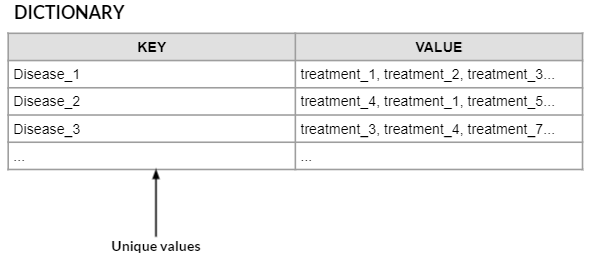

In [156]:
diseases = []
treatments = []
counter = 0
for l in Y_pred:
    if 'D' in l and 'T' in l:
        treatment = ''
        disease = ''
        sent = test_sentences_list[counter].split()
        print(sent)
        
        for index, i in enumerate(l):
            if i == 'D':
                print(sent[index])
                disease = disease + sent[index] + ' '
                
            if i == 'T':
                print(sent[index])
                treatment = treatment + sent[index] + ' '
                
        diseases.append(disease.strip(','))
        treatments.append(treatment.strip(','))
    
    counter += 1

['<', 'TO_SEE', '>', 'CONTEXT', ':', 'There', 'is', 'a', 'substantial', 'risk', 'of', 'a', 'second', 'cancer', 'for', 'persons', 'with', 'hereditary', 'retinoblastoma', ',', 'which', 'is', 'enhanced', 'by', 'radiotherapy']
hereditary
retinoblastoma
radiotherapy
['METHODS', ':', 'The', 'effect', 'of', 'roxithromycin', 'was', 'assessed', 'in', 'a', 'double-blind', ',', 'randomised', ',', 'prospective', ',', 'multicentre', ',', 'parallel-group', ',', 'placebo-controlled', 'pilot', 'study', 'of', '202', 'patients', 'with', 'unstable', 'angina', 'or', 'non-Q-wave', 'myocardial', 'infarction']
roxithromycin
unstable
angina
or
non-Q-wave
myocardial
infarction
['INTERPRETATION', ':', 'Antichlamydial', 'antibiotics', 'may', 'be', 'useful', 'in', 'therapeutic', 'intervention', 'in', 'addition', 'to', 'standard', 'medication', 'in', 'patients', 'with', 'coronary-artery', 'disease']
Antichlamydial
antibiotics
coronary-artery
disease
['<', 'TO_SEE', '>', 'FINDINGS', ':', 'G-CSF', 'therapy', 'was', 

In [157]:
final_output = pd.DataFrame({'Disease':diseases, 'Treatment':treatments})

### Predict the treatment for the disease name: 'hereditary retinoblastoma'

In [158]:
final_output[final_output['Disease'].str.contains('hereditary retinoblastoma')]

,Disease,Treatment
0,hereditary retinoblastoma,radiotherapy
